In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from datetime import date,tzinfo
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest 

In [2]:
dataset=pd.read_csv("Date&Transactionvalue.csv")

In [3]:
dataset

,Date,block,Transaction_value
0,2009-08-12,63,315000000000
1,2009-08-13,85,425000000000
2,2009-08-14,63,315000000000
3,2009-08-15,26,130000000000
4,2009-08-16,19,95000000000
...,...,...,...
4349,2021-07-09,733928,342560205304413
4350,2021-07-10,624905,185504058952898
4351,2021-07-11,549455,185854409979274
4352,2021-07-12,707519,167690416361542


In [4]:
data1=pd.read_csv("Transactions.csv")
data1

,Date,Transactions
0,2009-08-12,63
1,2009-08-13,85
2,2009-08-14,63
3,2009-08-15,26
4,2009-08-16,19
...,...,...
4349,2021-07-09,131
4350,2021-07-10,161
4351,2021-07-11,125
4352,2021-07-12,126


In [9]:
year =input("Please enter Initial year ")
yearf =input("Please enter final year ")
initial = int(year)
final = int(yearf)
#initial=int(initial_date)
#final=int(final_date)

Please enter Initial year 2019
Please enter final year 2020


In [10]:
result1 = pd.merge(data1,dataset,on='Date')
result1['Date'] = result1['Date'].astype('datetime64[ns]')
result2=result1.loc[result1['Date']<='01-08-2016']
result =result1.loc[(result1['Date'].dt.year>=initial) &(result1['Date'].dt.year<=final) ]
result

,Date,Transactions,block,Transaction_value
3429,2019-01-01,149,558327,54976665348468
3430,2019-01-02,151,657911,98571674337309
3431,2019-01-03,155,699373,94039796409401
3432,2019-01-04,149,693567,97245582287961
3433,2019-01-05,163,629683,76243509607456
...,...,...,...,...
4155,2020-12-27,148,879278,251461469764890
4156,2020-12-28,160,909933,198085200746056
4157,2020-12-29,152,982939,184594688181153
4158,2020-12-30,172,1021542,174350084672406


In [27]:
len(result)

731

In [12]:
result.describe()


,Transactions,block,Transaction_value
count,731.000000,7.310000e+02,7.310000e+02
mean,146.995896,8.293336e+05,1.441269e+14
std,15.188541,1.026329e+05,1.222337e+14
min,92.000000,5.345160e+05,4.219402e+13
25%,137.000000,7.559905e+05,8.736376e+13
50%,148.000000,8.225410e+05,1.172810e+14
75%,157.000000,9.022180e+05,1.743539e+14
max,196.000000,1.096850e+06,2.452867e+15


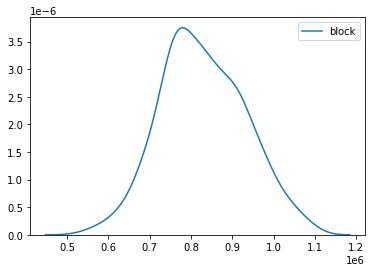

In [13]:
sns.kdeplot(result['block'])

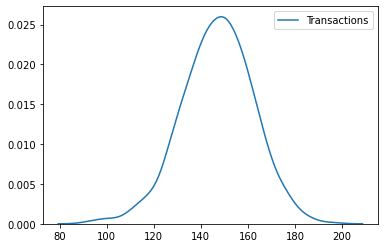

In [14]:
sns.kdeplot(result['Transactions'])

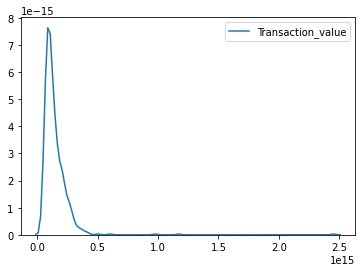

In [15]:
sns.kdeplot(result['Transaction_value'])

Text(0.5, 1.0, 'Transactions per year')

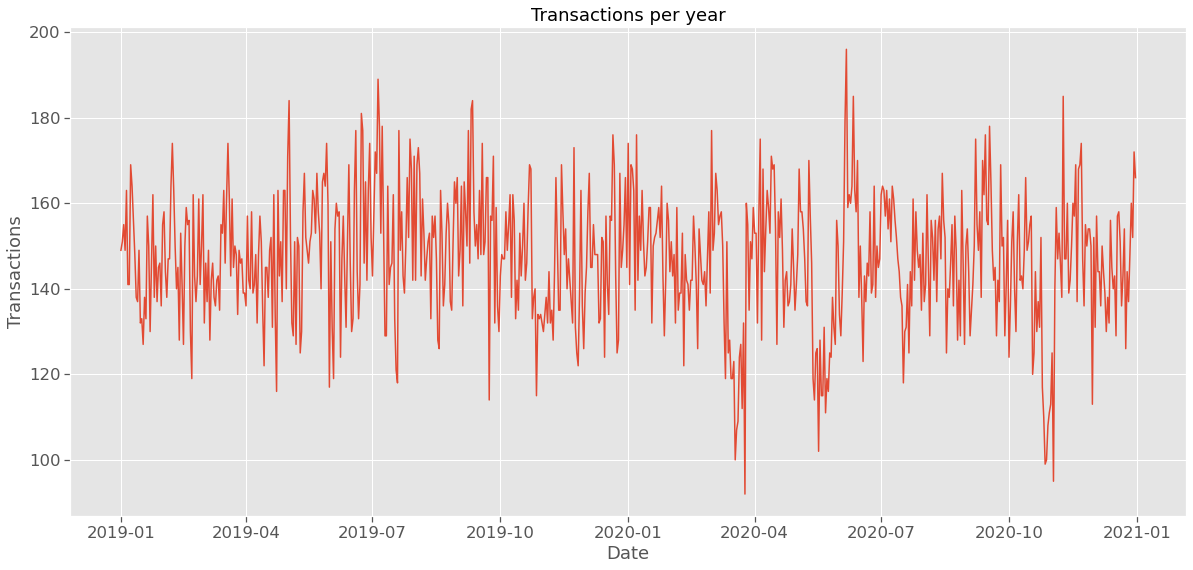

In [16]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Transactions', data=result, palette='Blues_d')
plt.title('Transactions per year')

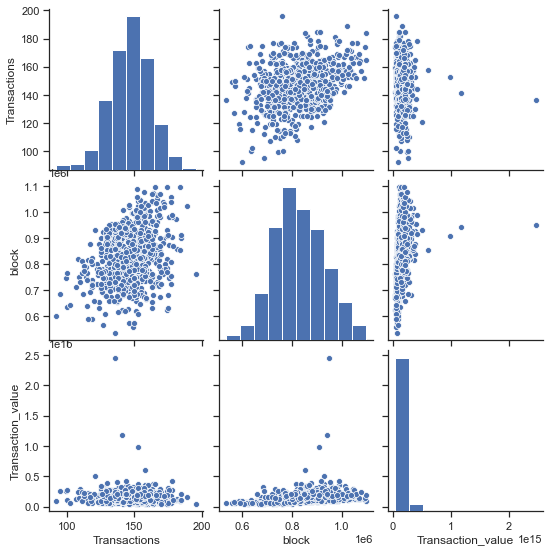

In [19]:
sns.set(style="ticks")
sns.pairplot(result)

In [20]:
#data2=result.loc[result['Date']>='2013-08-12']
data2 = result2[['Transaction_value','block','Transactions']]
data3 = result[['Transaction_value','block','Transactions']]
outliers_fraction=0.05
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data2)
data2 = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data2)

IsolationForest(contamination=0.05)

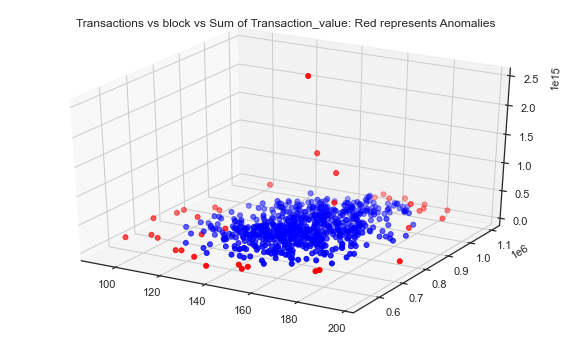

In [21]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111,projection='3d')
X = result.iloc[:,1:4].values
colors = np.array(['red', 'blue'])
y_pred = model.fit_predict(data3)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=25, color=colors[(y_pred + 1) // 2] )
#ax.legend()
#plt.xlabel('Transactions')
#plt.ylabel('Blocks')
#plt.zlabel('Sum of Output Satoshis')
plt.title('Transactions vs block vs Sum of Transaction_value: Red represents Anomalies')
plt.savefig('IsolationForest_anomaly.png', dpi=1000)

In [22]:
result['anomaly_IsolationForest'] = model.predict(data3)
result['anomaly_IsolationForest'] = result['anomaly_IsolationForest'].apply(lambda x: x == -1)
result['anomaly_IsolationForest'] = result['anomaly_IsolationForest'].astype(int)
result['anomaly_IsolationForest'].value_counts()

0    694
1     37
Name: anomaly_IsolationForest, dtype: int64

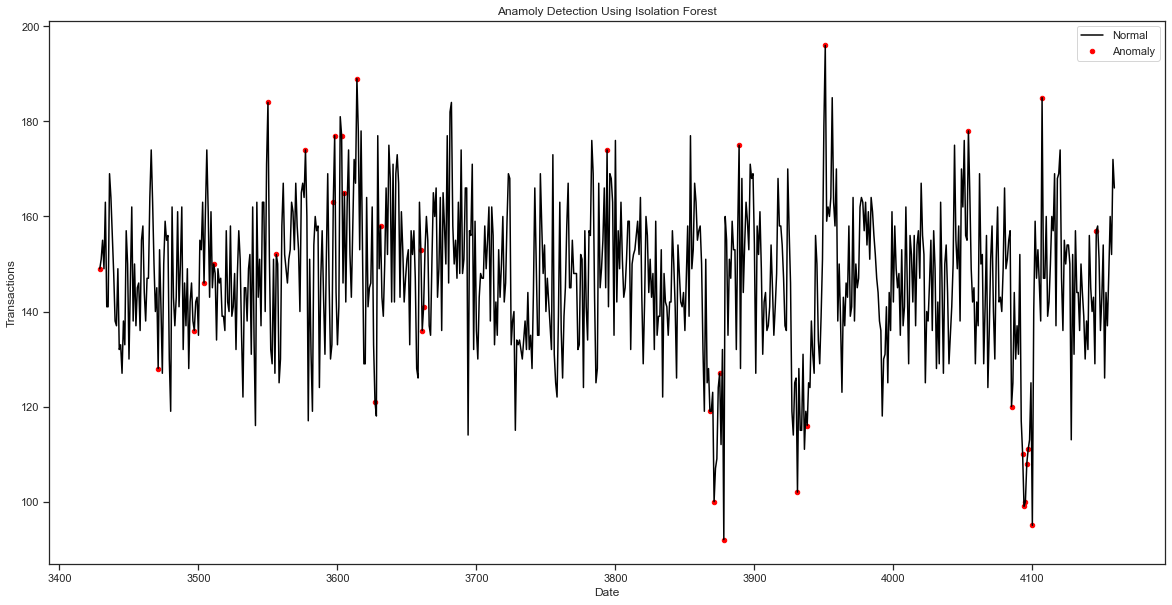

In [23]:
fig, ax = plt.subplots(figsize=(20,10))

#anomaly
a = result.loc[result['anomaly_IsolationForest'] == 1]
ax.plot(result['Transactions'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=20)
plt.legend()
plt.title("Anamoly Detection Using Isolation Forest")
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.savefig('IsolationForest_anomaly_Transactions.png')
plt.show();

In [24]:
result.head(5)

,Date,Transactions,block,Transaction_value,anomaly_IsolationForest
3429,2019-01-01,149,558327,54976665348468,1
3430,2019-01-02,151,657911,98571674337309,0
3431,2019-01-03,155,699373,94039796409401,0
3432,2019-01-04,149,693567,97245582287961,0
3433,2019-01-05,163,629683,76243509607456,0


In [25]:
## the dates and the no of transactions found to be anamoly

In [26]:
final_anomaly = result.query('anomaly_IsolationForest == 1')
final_anomaly

,Date,Transactions,block,Transaction_value,anomaly_IsolationForest
3429,2019-01-01,149,558327,54976665348468,1
3471,2019-02-12,128,682877,317662877211775,1
3497,2019-03-10,136,534516,66293708096304,1
3504,2019-03-17,146,573366,69144407091008,1
3511,2019-03-24,150,572958,63586866118432,1
3550,2019-05-02,184,1096850,98656356920911,1
3556,2019-05-08,152,1090843,128282063528942,1
3577,2019-05-29,174,1094814,142645261513318,1
3597,2019-06-18,163,1044628,286989919444804,1
3598,2019-06-19,177,1059323,167318262682240,1
